In [13]:
import matplotlib.pyplot as plt
import scgenome.plotting as pl
import anndata
import os

plot_size = (8, 4)
plot_dpi = 300

In [14]:
dataset_path = "../../datasets/MM24.h5ad"
out_path = "../../output_MM24_K14"
victree_out = os.path.join(out_path, "victree.out.h5ad")
in_ad = anndata.read_h5ad(dataset_path)
ad = anndata.read_h5ad(victree_out)
ad

/Users/zemp/miniconda3/envs/victree310/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2208 × 5298
    obs: 'victree-mu', 'victree-mt-lambda', 'victree-mt-alpha', 'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'
    var: 'target_bin', 'chr', 'start', 'end'
    uns: 'victree-elbo', 'victree-eps-alpha', 'victree-eps-beta', 'victree-tree-graph', 'victree-tree-newick', 'victree-tree-probs'
    obsm: 'victree-clone-probs'
    varm: 'victree-cn-pprobs', 'victree-cn-sprobs'
    layers: 'victree-cn-marginal', 'victree-cn-viterbi'

In [15]:
in_ad.var['chr'] = in_ad.var['chr'].map({c: c[3:] for c in in_ad.var['chr'].unique()})

## VICTree K=14

/Users/zemp/miniconda3/envs/victree310/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


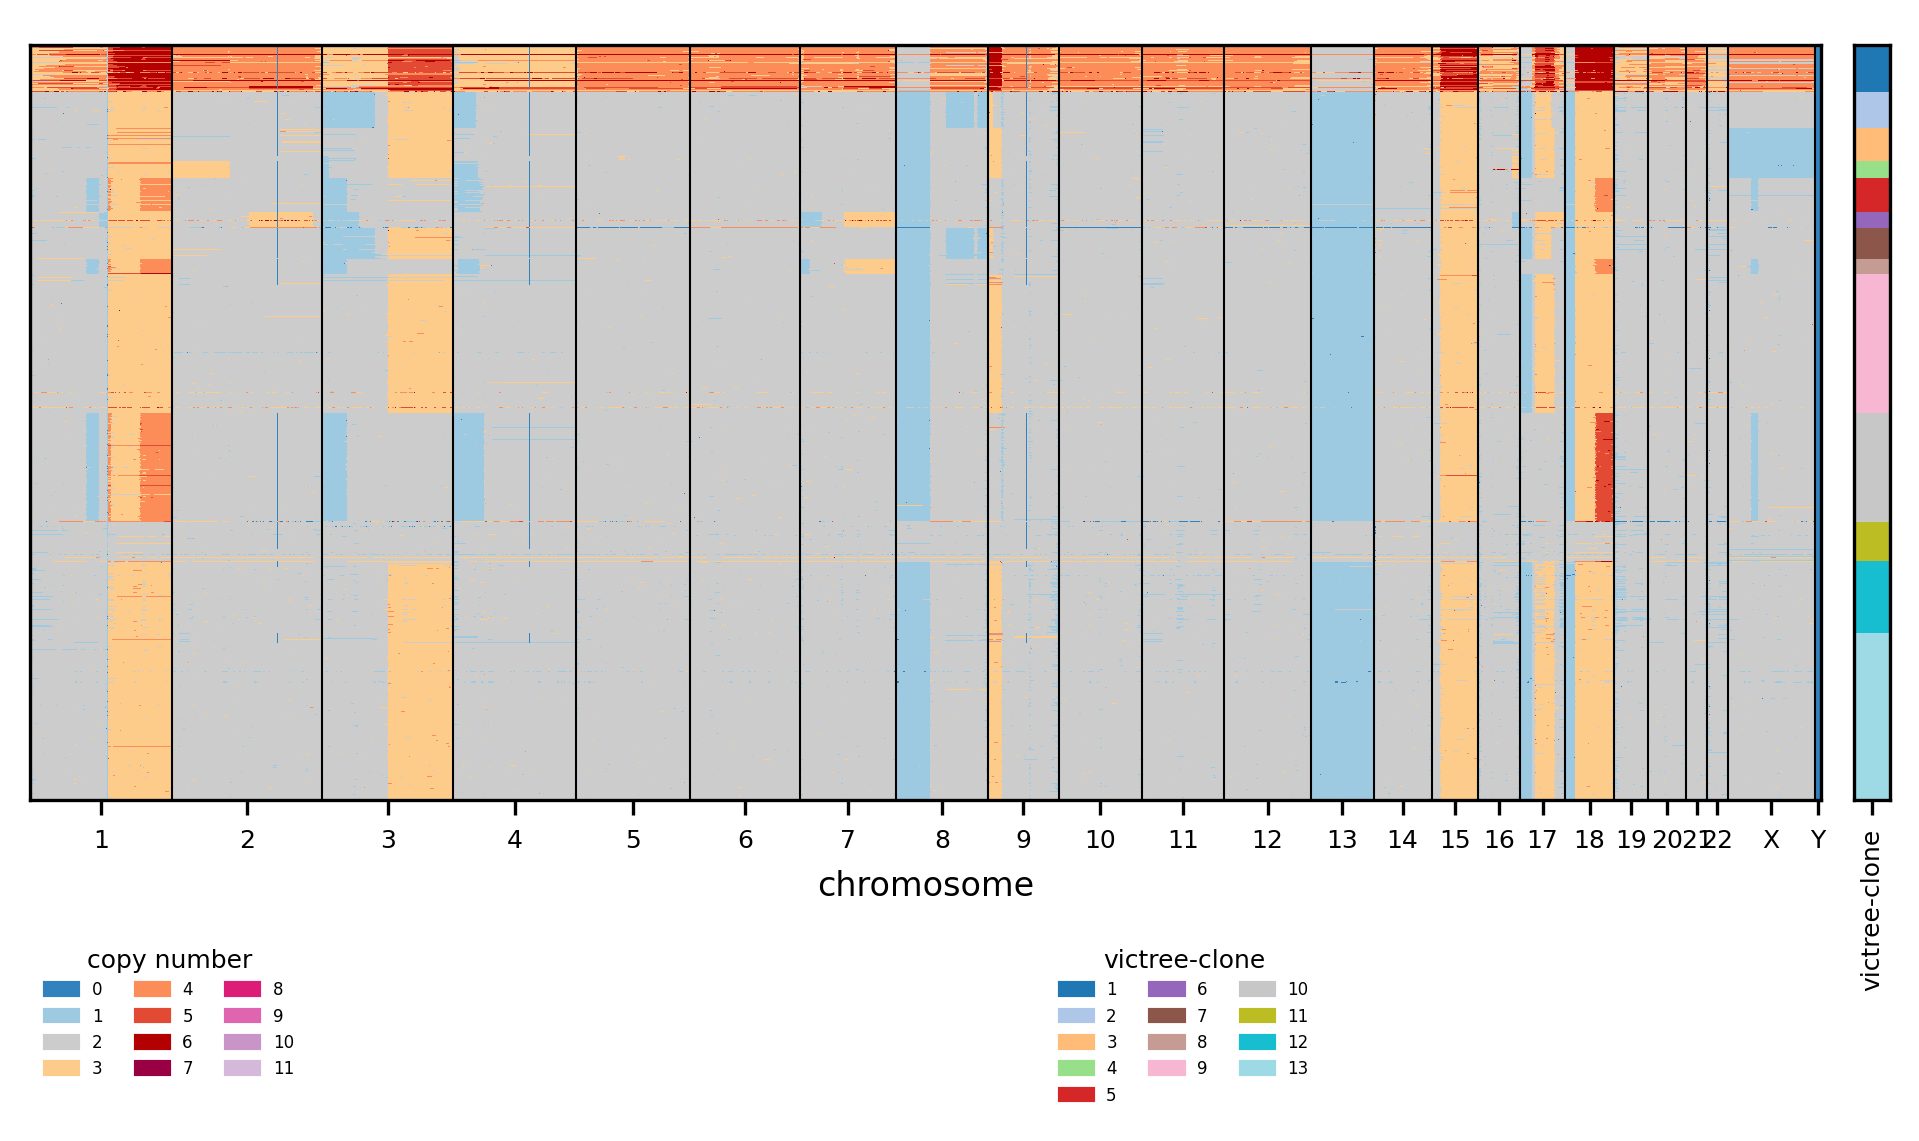

In [16]:
in_ad.obs['victree-clone'] = ad.obs.set_index(in_ad.obs_names)['victree-clone']
in_ad.layers['copy number'] = in_ad.layers['state']
g = pl.plot_cell_cn_matrix_fig(in_ad, 'copy number', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'])
gfig = g['fig']
gfig.set_size_inches(*plot_size)
gfig.set_dpi(plot_dpi)
gfig.savefig(os.path.join(out_path, "hmmcopy_cn.png"))

/Users/zemp/miniconda3/envs/victree310/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


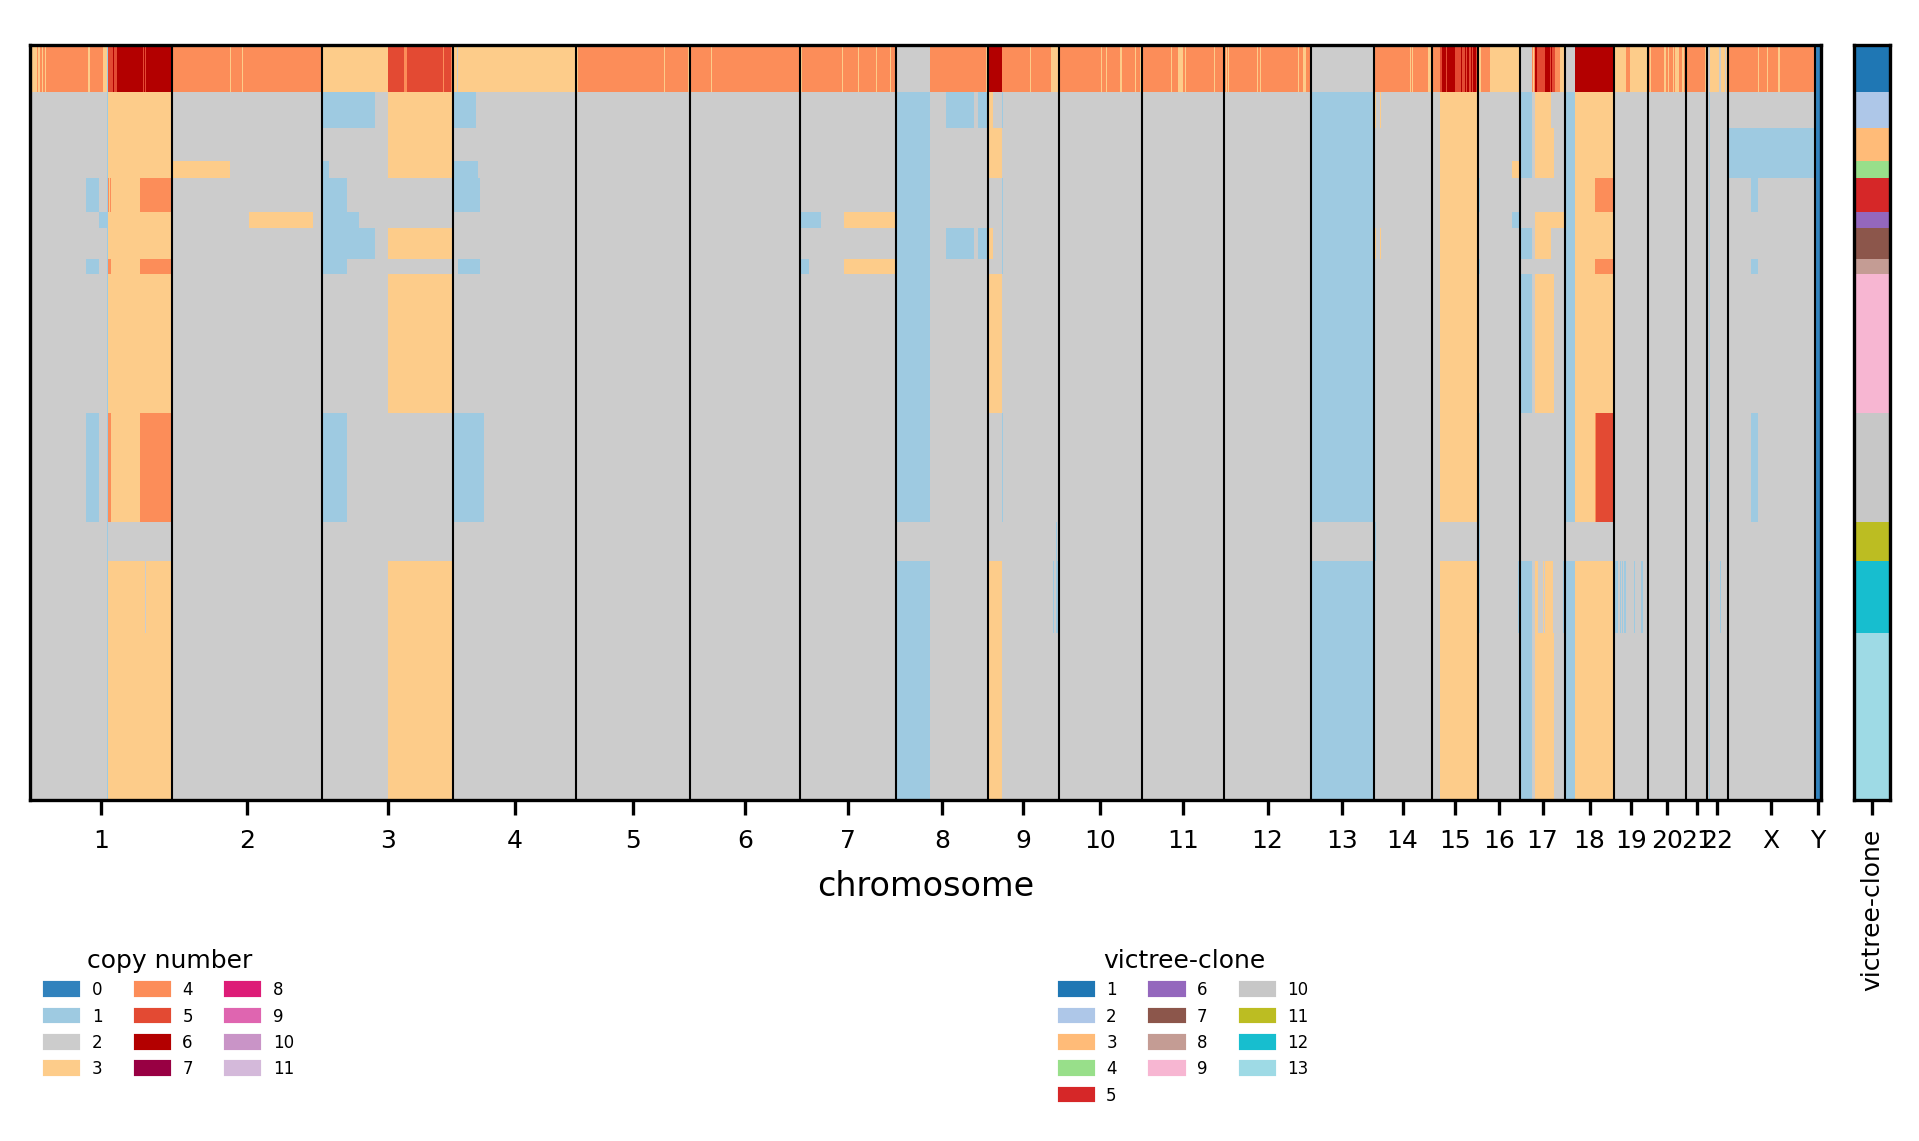

In [19]:
ad.layers['copy number'] = ad.layers['victree-cn-viterbi']
g = pl.plot_cell_cn_matrix_fig(ad, 'copy number', max_cn=6, cell_order_fields=['victree-clone'], annotation_fields=['victree-clone'])
gfig = g['fig']
gfig.set_size_inches(*plot_size)
gfig.set_dpi(plot_dpi)
gfig.savefig(os.path.join(out_path, "victree_cn.png"))

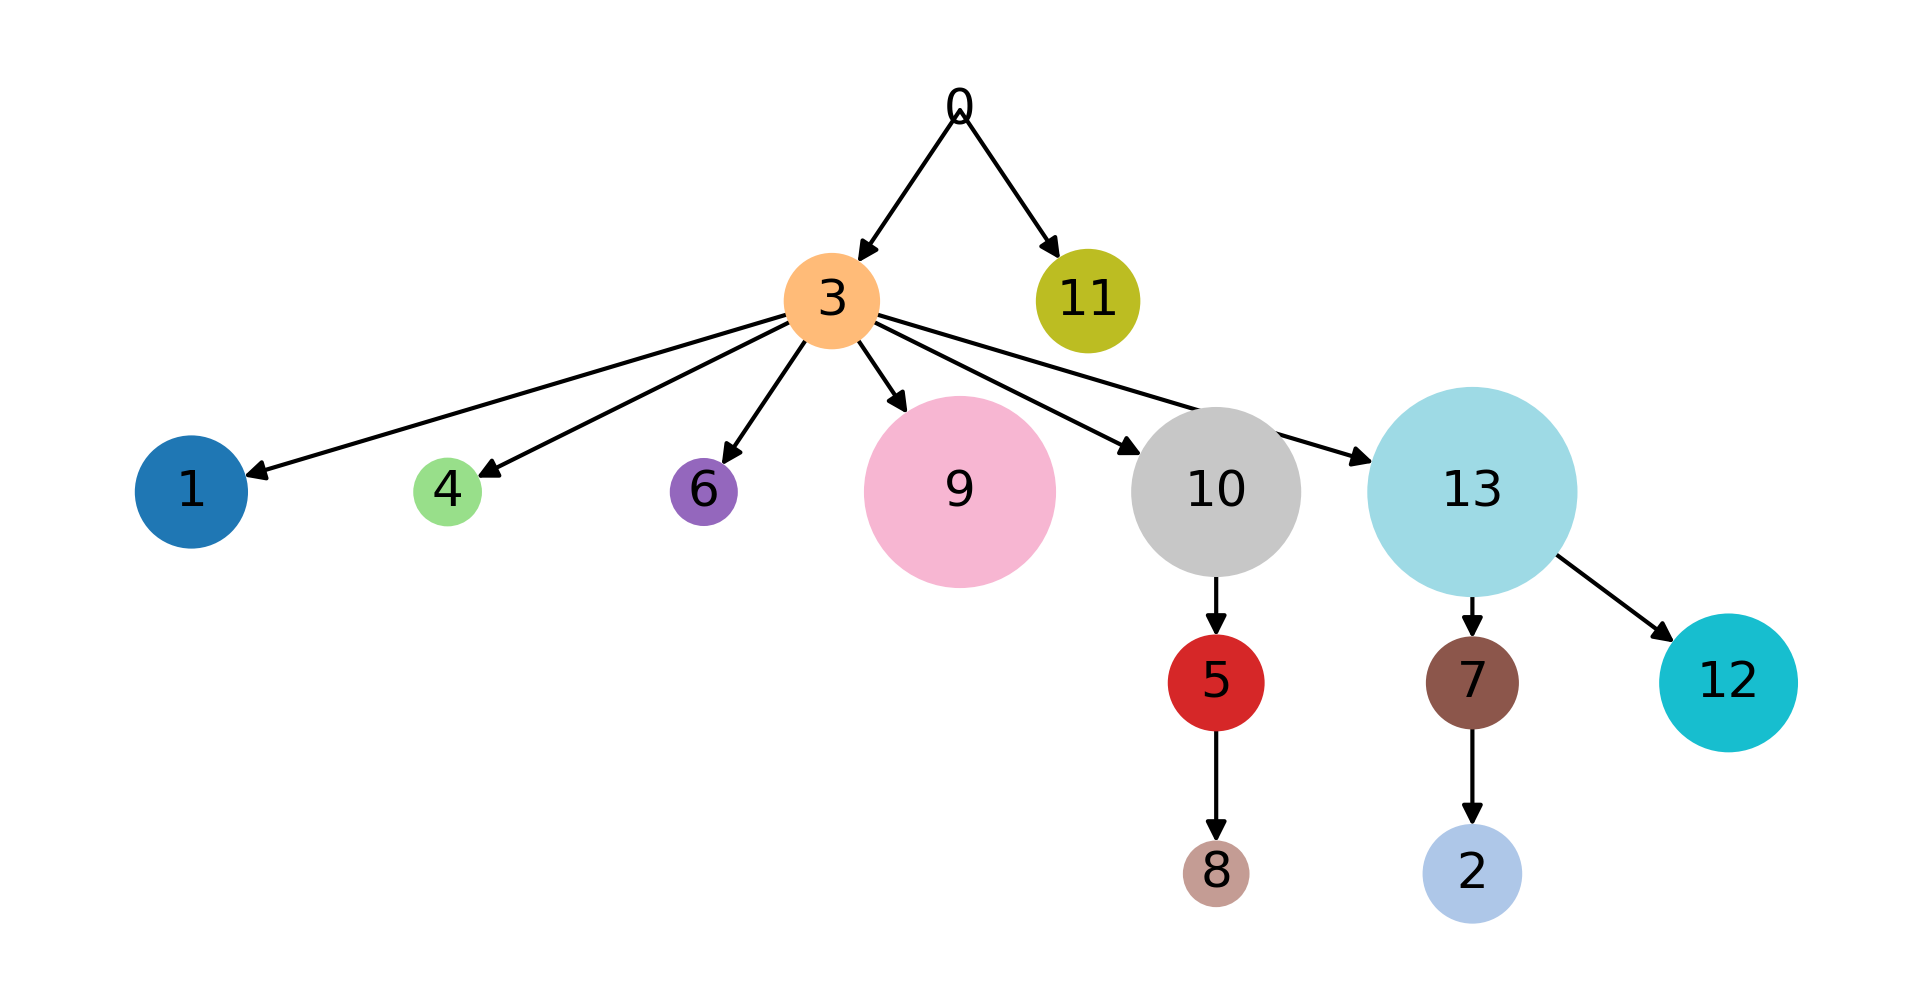

In [20]:
from io import StringIO
from utils.tree_utils import parse_newick, tree_to_newick
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import numpy as np

tree_newick =str(ad.uns['victree-tree-newick'][0], 'UTF-8')
tree = parse_newick(StringIO(tree_newick))
tree = nx.relabel_nodes(tree, {str(i): i for i in range(len(tree.nodes()))})
pos = graphviz_layout(tree, prog='dot')
col_dict = g['annotation_info']['victree-clone']['level_colors']
col_dict[0] = np.array([189, 195, 199, 1.]) / np.array([255, 255, 255, 1.])
colors = [col_dict[i] for i in tree.nodes()]
clone_counts = np.unique(ad.obs['victree-clone'], return_counts=True)
node_size_dict = {a[0]: a[1] for a in zip(*clone_counts)}
node_size_dict[0] = 0
node_size = [node_size_dict[i] * 5 for i in tree.nodes()]
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
nx.draw(tree, node_color=colors, with_labels=True, pos=pos, node_size=node_size, ax=ax)
fig.savefig(os.path.join(out_path, "treeplot.png"))